<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/main/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Setup & Imports

In [69]:
import os, json, random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import Counter
from sklearn.metrics import f1_score

In [70]:
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## 2) Config & Label Map

In [71]:
# --- Config ---
IMG_SIZE     = 224          # images will be resized to 224x224 pixels
BATCH_SIZE   = 32           # how many images you train on at once (per step)
EPOCHS       = 25           # how many full passes over the training set
LR           = 1e-4         # learning rate (how big each weight update is)
WEIGHT_DECAY = 1e-4         # L2 regularization to reduce overfitting
POOL_TYPE    = "max"        # choose pooling type: "max" or "avg" in your CNN
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # ^ use GPU (CUDA) if available, otherwise CPU
SEED         = 42           # random seed for reproducibility

random.seed(SEED); torch.manual_seed(SEED)
# ^ fix Python and PyTorch randomness so results are more repeatable

BASE_DIR = "/content/ann-visual-emotion/data/processed/EmoSet_splits"
BASE_DATA_URL = "/content/ann-visual-emotion"

# File paths
CSV_TRAIN = f"{BASE_DIR}/train.csv"
CSV_VAL   = f"{BASE_DIR}/val.csv"
CSV_TEST  = f"{BASE_DIR}/test.csv"

# Label mapping for 8 emotions
label_map = {
    "amusement": 0, "anger": 1, "awe": 2, "contentment": 3,
    "disgust": 4, "excitement": 5, "fear": 6, "sadness": 7
}

id_to_label = {v:k for k,v in label_map.items()}


## 3) Load CSVs & Quick EDA

In [72]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df.head())

Train: 13864 Val: 1734 Test: 1734
                                          image_path        label
0  data/raw/EmoSet/contentment/contentment_09260.jpg  contentment
1              data/raw/EmoSet/anger/anger_06224.jpg        anger
2  data/raw/EmoSet/contentment/contentment_03550.jpg  contentment
3          data/raw/EmoSet/sadness/sadness_08827.jpg      sadness
4  data/raw/EmoSet/contentment/contentment_09558.jpg  contentment



## 4) Dataset & Transforms

In [73]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(BASE_DATA_URL, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        y = label_map[row['label']]
        if self.transform: img = self.transform(img)
        return img, y

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.15,0.15,0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = EmotionDataset(train_df, transform=train_tfms)
val_ds   = EmotionDataset(val_df,   transform=eval_tfms)
test_ds  = EmotionDataset(test_df,  transform=eval_tfms)

In [74]:
cnts = Counter(train_df['label'])
freq = torch.tensor([cnts[k] for k in label_map.keys()], dtype=torch.float32)
class_weights = (freq.sum() / (len(freq) * torch.clamp(freq, min=1)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Class weights:", class_weights)

Class weights: tensor([ 0.5689,  1.5487,  3.5295,  0.6899, 82.5238,  0.3530,  4.7873,  1.2352])


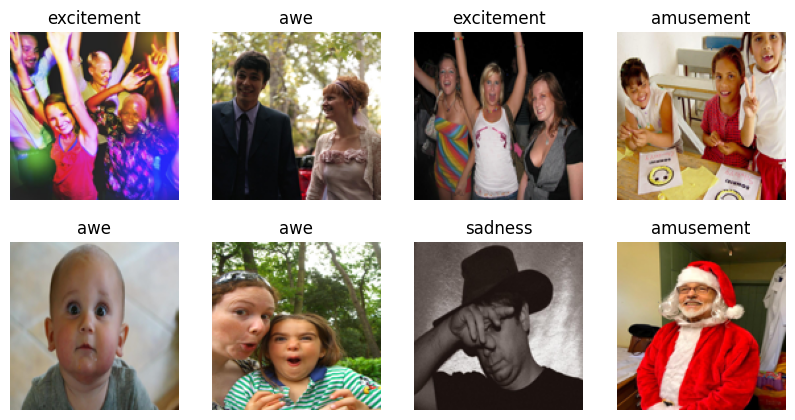

In [75]:
# This cell may need display support depending on your environment.
# It simply shows a handful of raw images (without transforms).

try:
    import random
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    for ax in axes.ravel():
        i = random.randint(0, len(train_df)-1)
        path = f"{BASE_DATA_URL}/{train_df.iloc[i]['image_path']}"
        emotion = train_df.iloc[i]['label']
        img = Image.open(path).convert("RGB").resize((128,128))
        ax.imshow(img)
        ax.set_title(emotion)
        ax.axis('off')
    plt.show()
except Exception as e:
    print("Skipping preview (could not load images here):", e)


## 6) Define a Simple CNN (Conv → ReLU → Pool → Dense)

In [76]:

class SimpleCNN(nn.Module):
    """Three Conv blocks. Each has:
       Conv2d(kernel=3, stride=1, padding=1) -> ReLU -> Pool(2x2)
       Then Flatten -> Dense(256) -> Dropout -> Dense(8 classes)
       Padding=1 with kernel=3 keeps H,W same before pooling.
    """
    def __init__(self, pool_type="max"):
        super().__init__()
        self.conv1 = nn.Conv2d(3,   32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        self.conv2 = nn.Conv2d(32,  64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2,2) if pool_type=='max' else nn.AvgPool2d(2,2)

        # after 3 pools: 224 -> 112 -> 56 -> 28
        flattened = 128 * (IMG_SIZE//8) * (IMG_SIZE//8)  # 128*28*28

        self.fc1 = nn.Linear(flattened, 256)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, len(label_map))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool1(x)
        x = self.relu(self.conv2(x)); x = self.pool2(x)
        x = self.relu(self.conv3(x)); x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)); x = self.drop(x)
        x = self.fc2(x)
        return x

# Quick shape check
with torch.no_grad():
    tmp = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
    m = SimpleCNN(pool_type=POOL_TYPE)
    out = m(tmp)
    print("Output logits shape:", out.shape, "(should be [1, 8])")


Output logits shape: torch.Size([1, 8]) (should be [1, 8])


## 7) Training Loop (Backpropagation)

In [77]:

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()           # 0) clear old gradients
        logits = model(images)          # 1) forward
        loss = criterion(logits, labels)# 2) compute loss
        loss.backward()                 # 3) backprop (compute gradients)
        optimizer.step()                # 4) update weights

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss/total, running_correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss/total, running_correct/total

## 8) Fit the Model (Train + Validate)

In [ ]:

model = SimpleCNN(pool_type=POOL_TYPE).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val_acc = 0.0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.4f} || val_loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "checkpoints/simple_cnn_best.pt")
        print("  -> saved best checkpoint")

Epoch 01 | train_loss 1.6242 acc 0.3871 || val_loss 1.5552 acc 0.4158
  -> saved best checkpoint
Epoch 02 | train_loss 1.5512 acc 0.4256 || val_loss 1.5173 acc 0.4412
  -> saved best checkpoint
Epoch 03 | train_loss 1.5151 acc 0.4388 || val_loss 1.5066 acc 0.4481
  -> saved best checkpoint
Epoch 04 | train_loss 1.4861 acc 0.4544 || val_loss 1.4854 acc 0.4423
Epoch 05 | train_loss 1.4502 acc 0.4728 || val_loss 1.4675 acc 0.4475
Epoch 06 | train_loss 1.4269 acc 0.4842 || val_loss 1.4664 acc 0.4521
  -> saved best checkpoint


In [ ]:
model.load_state_dict(torch.load("best.pt"))
test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion)
print("Test: acc=", test_acc, " f1=", test_f1)